# Uncovering the Drivers of Housing Prices in Beijing: The Influence of Location and Time

In [41]:
# Import packages
library(tidyverse)
library(lubridate) 
library(repr)
library(corrplot)
library(cowplot)
library(ggmap)
library(mapproj)
library(viridis)

## 1. Data cleaning and wrangling

#### The text description part of the project is not working at the moment.

In [14]:
# Load the dataset
housing_data <- read_csv("data/Beijinghouse.csv", locale = locale(encoding = "UTF-8")) %>%
  mutate(floor = str_trim(str_extract(floor,"( .*)"), side = "both"))
# # Explore the structure and summary statistics of the dataset
print(head(housing_data))
# Save the summary of the dataset to a text file
summary(housing_data)

Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 318851 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): url, id, floor, constructionTime
dbl  (21): Lng, Lat, Cid, DOM, followers, totalPrice, price, square, livingR...
date  (1): tradeTime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 6 × 26
  url      id      Lng   Lat     Cid tradeTime    DOM followers totalPrice price
  <chr>    <chr> <dbl> <dbl>   <dbl> <date>     <dbl>     <dbl>      <dbl> <dbl>
1 https:/… 1010…  116.  40.0 1.11e12 2016-08-09  1464       106       415  31680
2 https:/… 1010…  116.  39.9 1.11e12 2016-07-28   903       126       575  43436
3 https:/… 1010…  117.  39.9 1.11e12 2016-12-11  1271        48      1030  52021
4 https:/… 1010…  116.  40.1 1.11e12 2016-09-30   965       138       298. 22202
5 https:/… 1010…  116.  39.9 1.11e12 2016-08-28   927       286       392  48396
6 https:/… 1010…  116.  40.0 1.11e12 2016-07-22   861        57       276. 52000
# ℹ 16 more variables: square <dbl>, livingRoom <dbl>, drawingRoom <dbl>,
#   kitchen <dbl>, bathRoom <dbl>, floor <chr>, buildingType <dbl>,
#   constructionTime <chr>, renovationCondition <dbl>, buildingStructure <dbl>,
#   ladderRatio <dbl>, elevator <dbl>, fiveYearsProperty <dbl>, subway <dbl>,
#   district <dbl>, communityAver

     url                 id                 Lng             Lat       
 Length:318851      Length:318851      Min.   :116.1   Min.   :39.63  
 Class :character   Class :character   1st Qu.:116.3   1st Qu.:39.89  
 Mode  :character   Mode  :character   Median :116.4   Median :39.93  
                                       Mean   :116.4   Mean   :39.95  
                                       3rd Qu.:116.5   3rd Qu.:40.00  
                                       Max.   :116.7   Max.   :40.25  
                                                                      
      Cid              tradeTime               DOM            followers      
 Min.   :1.111e+12   Min.   :2002-06-01   Min.   :   1.00   Min.   :   0.00  
 1st Qu.:1.111e+12   1st Qu.:2013-11-30   1st Qu.:   1.00   1st Qu.:   0.00  
 Median :1.111e+12   Median :2015-09-12   Median :   6.00   Median :   5.00  
 Mean   :1.129e+12   Mean   :2015-04-17   Mean   :  28.82   Mean   :  16.73  
 3rd Qu.:1.111e+12   3rd Qu.:2016-07-31   

#### Missing value check

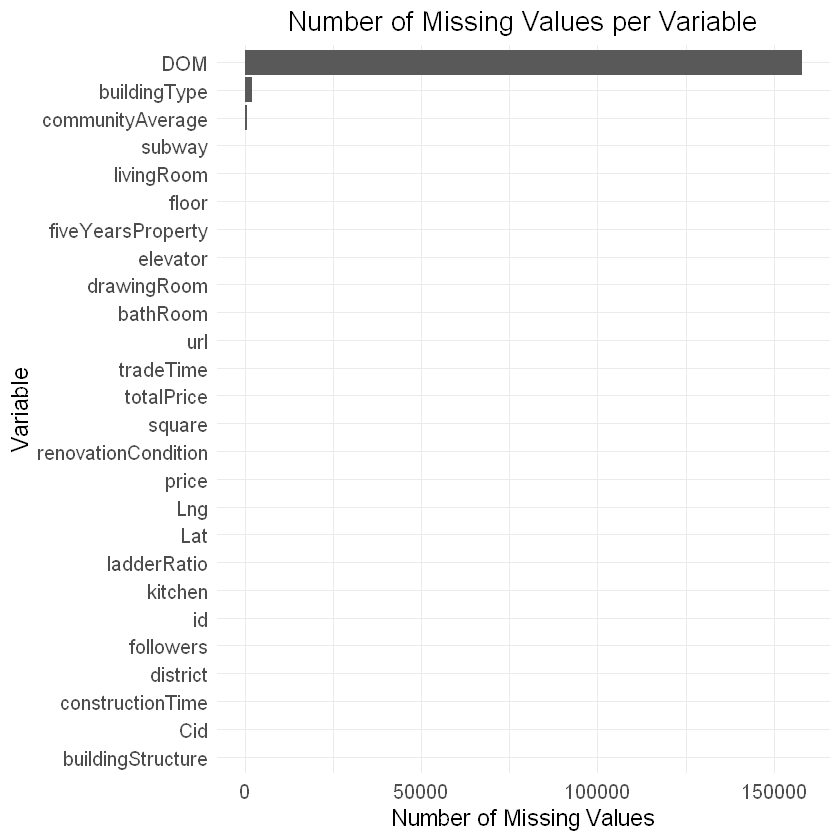

In [9]:
# Load the preprocessed data
na_count <- housing_data %>%
  summarise(across(everything(), ~sum(is.na(.)))) %>%
  pivot_longer(everything(), names_to = "Variable", values_to = "NA_count")

# Generate the plot with a white background
na_plot <- ggplot(na_count, aes(x = reorder(Variable, NA_count), y = NA_count)) +
  geom_bar(stat = "identity") +
  coord_flip() +  # Flip the axes to make the bars horizontal
  labs(x = "Variable", y = "Number of Missing Values", 
       title = "Number of Missing Values per Variable") +
  theme_minimal(base_size = 12) + # Use a minimal theme with base font size set
  theme(
    plot.background = element_rect(fill = "white", colour = "white"), # Set the plot background color to white
    panel.background = element_rect(fill = "white", colour = "white"), # Set the panel background color to white
    text = element_text(size = 12), # Adjust the text size
    axis.title = element_text(size = 14), # Adjust the size of axis titles
    axis.text = element_text(size = 12), # Adjust the size of axis text
    plot.title = element_text(size = 16, hjust = 0.5) # Center the plot title and set its size
  )
na_plot

In [10]:
# we decided drop DOM columns (Beccause DOM's data have more than 90% are missing), and drop other missing values (The other misses are few that we just drop them).
beijing_house_price <- housing_data %>% 
                                select(-DOM,-url, -id, -Cid)%>% 
                                drop_na()
# Perform the final check for missing values
na_check_results <- sapply(beijing_house_price, function(x) sum(is.na(x)))
# Print the results to the console
print(na_check_results)

                Lng                 Lat           tradeTime           followers 
                  0                   0                   0                   0 
         totalPrice               price              square          livingRoom 
                  0                   0                   0                   0 
        drawingRoom             kitchen            bathRoom               floor 
                  0                   0                   0                   0 
       buildingType    constructionTime renovationCondition   buildingStructure 
                  0                   0                   0                   0 
        ladderRatio            elevator   fiveYearsProperty              subway 
                  0                   0                   0                   0 
           district    communityAverage 
                  0                   0 


#### Feature engineering and category variable processing

In [11]:
# Transforming categorical variables into readable factors with proper labels according to variable discription
beijing_house_price_cleaned <- beijing_house_price %>%
  mutate(
    # Change 'buildingType' numerical codes into descriptive categories
    buildingType = case_when(
      buildingType == 1 ~ "Tower",
      buildingType == 2 ~ "Bungalow",
      buildingType == 3 ~ "Plate/Tower",
      buildingType == 4 ~ "Plate"
    ),

    # Change 'renovationCondition' numerical codes into descriptive categories
    renovationCondition = case_when(
      renovationCondition == 1 ~ "Other",
      renovationCondition == 2 ~ "Rough",
      renovationCondition == 3 ~ "Simplicity",
      renovationCondition == 4 ~ "Hardcover"
    ),

    # Change 'buildingStructure' numerical codes into descriptive categories
    buildingStructure = case_when(
      buildingStructure == 1 ~ "Unavailable",
      buildingStructure == 2 ~ "Mixed",
      buildingStructure == 3 ~ "Brick/Wood",
      buildingStructure == 4 ~ "Brick/Concrete",
      buildingStructure == 5 ~ "Steel",
      buildingStructure == 6 ~ "Steel/Concrete"
    ),

    # Encode 'elevator' presence as a categorical variable
    elevator = case_when(
      elevator == 1 ~ "Has_Elevator",
      elevator != 1 ~ "No_elevator"
    ),

    # Encode 'subway' proximity as a categorical variable
    subway = case_when(
      subway == 1 ~ "Has_Subway",
      subway != 1 ~ "No_Subway"
    ),

    # Encode 'fiveYearsProperty' as a categorical variable indicating ownership duration
    fiveYearsProperty = case_when(
      fiveYearsProperty == 1 ~ "Ownership < 5years",
      fiveYearsProperty != 1 ~ "Ownership > 5years"
    ),

    # Change 'district' numerical codes into descriptive categories
    district = case_when(
      district == 1 ~ "DongCheng",
      district == 2 ~ "FengTai",
      district == 3 ~ "DaXing",
      district == 4 ~ "FaXing",
      district == 5 ~ "FangShang",
      district == 6 ~ "ChangPing",
      district == 7 ~ "ChaoYang",
      district == 8 ~ "HaiDian",
      district == 9 ~ "ShiJingShan",
      district == 10 ~ "XiCheng",
      district == 11 ~ "TongZhou",
      district == 12 ~ "ShunYi",
      district == 13 ~ "MenTouGou"
    )
  ) %>%
  # Convert the new descriptive categories into factor variables
  mutate(
    renovationCondition = as.factor(renovationCondition),
    buildingStructure = as.factor(buildingStructure),
    elevator = as.factor(elevator),
    subway = as.factor(subway),
    fiveYearsProperty = as.factor(fiveYearsProperty),
    district = as.factor(district)
  )

#### Now data are tidy

In [13]:
head(beijing_house_price_cleaned)

Lng,Lat,tradeTime,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,⋯,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
<dbl>,<dbl>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>
116.4755,40.01952,2016-08-09,106,415.0,31680,131.00,2,1,1,⋯,Tower,2005,Simplicity,Steel/Concrete,0.217,Has_Elevator,Ownership > 5years,Has_Subway,ChaoYang,56021
116.4539,39.88153,2016-07-28,126,575.0,43436,132.38,2,2,1,⋯,Tower,2004,Hardcover,Steel/Concrete,0.667,Has_Elevator,Ownership < 5years,No_Subway,ChaoYang,71539
116.5620,39.87714,2016-12-11,48,1030.0,52021,198.00,3,2,1,⋯,Plate,2005,Simplicity,Steel/Concrete,0.500,Has_Elevator,Ownership > 5years,No_Subway,ChaoYang,48160
116.4380,40.07611,2016-09-30,138,297.5,22202,134.00,3,1,1,⋯,Tower,2008,Other,Steel/Concrete,0.273,Has_Elevator,Ownership > 5years,No_Subway,ChangPing,51238
116.4284,39.88623,2016-08-28,286,392.0,48396,81.00,2,1,1,⋯,Plate,1960,Rough,Mixed,0.333,No_elevator,Ownership < 5years,Has_Subway,DongCheng,62588
116.4663,39.99136,2016-07-22,57,275.6,52000,53.00,1,0,1,⋯,Plate,2005,Simplicity,Steel/Concrete,0.333,Has_Elevator,Ownership < 5years,No_Subway,ChaoYang,67738


## 2. Data EDA

[1] 347.8663

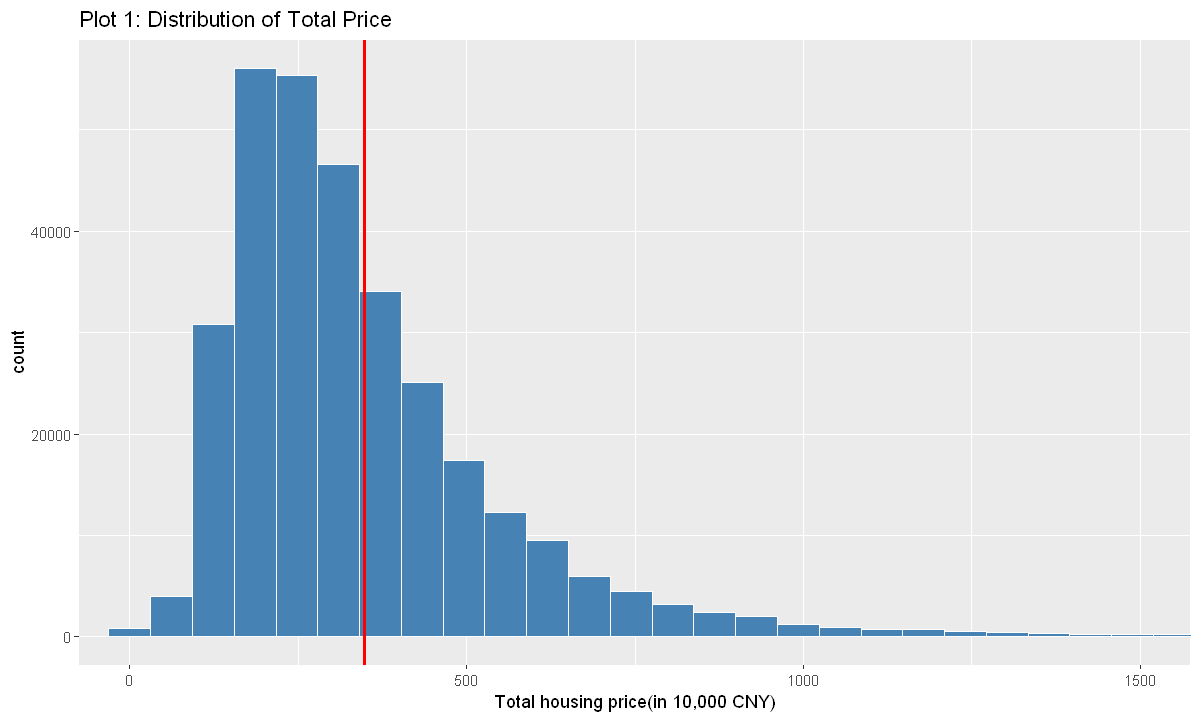

In [44]:
# First,let's explore the total price distribution of the houses
options(repr.plot.width=10, repr.plot.height=6)
mean_price <- mean(beijing_house_price_cleaned$totalPrice, na.rm = TRUE)
Price_distribution_plot <- ggplot(beijing_house_price_cleaned, aes(x = totalPrice)) + 
  geom_histogram(fill = "steelblue", color = "white", bins = 80) + 
  geom_vline(xintercept = mean(beijing_house_price_cleaned$totalPrice, na.rm = TRUE), 
             col = "red", size = 1) +
  labs(title = "Plot 1: Distribution of Total Price", 
       x = "Total housing price(in 10,000 CNY)") +
  coord_cartesian(xlim = c(0, 1500))  # Set the x-axis view limits
Price_distribution_plot
mean_price

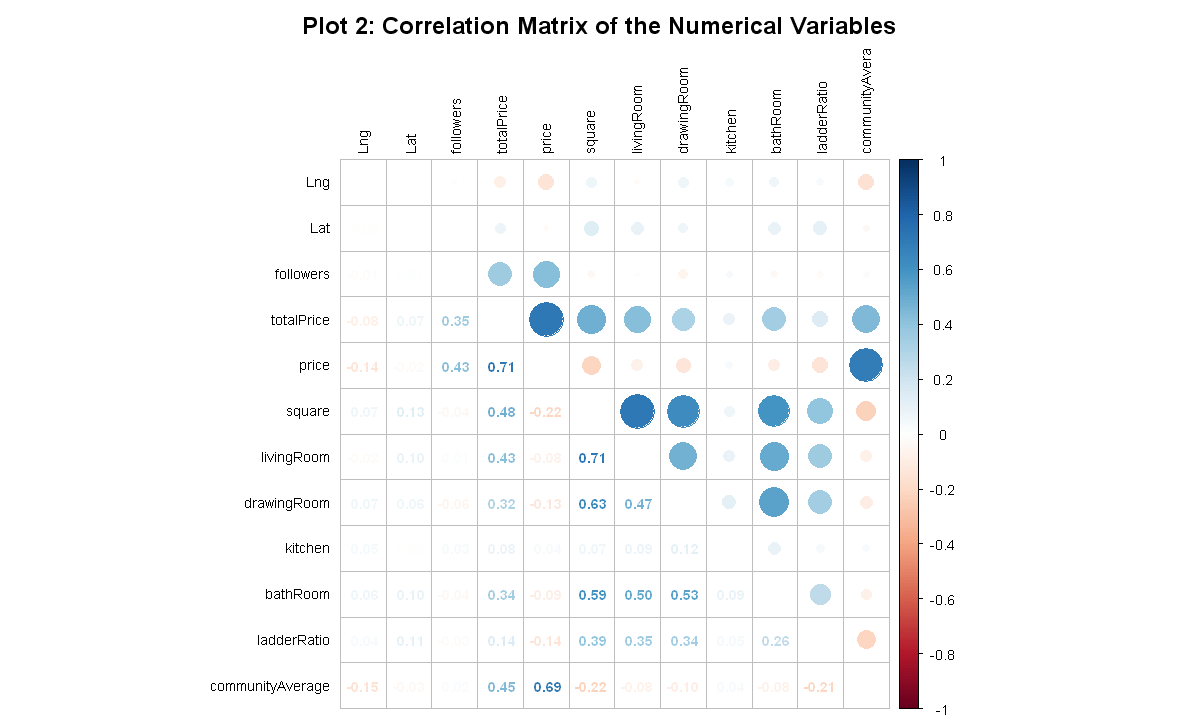

In [20]:
options(repr.plot.width=10, repr.plot.height=6)
cor_numVar <- cor(select_if(beijing_house_price_cleaned, is.numeric), 
                  use = "complete.obs", method = "spearman")
corrplot.mixed(cor_numVar, 
               tl.col = "black", 
               tl.pos = "lt", 
               tl.cex = 0.7, 
               cl.cex = 0.7, 
               number.cex = 0.7,
               title = "Plot 2: Correlation Matrix of the Numerical Variables",
               mar = c(0,0,2,0))

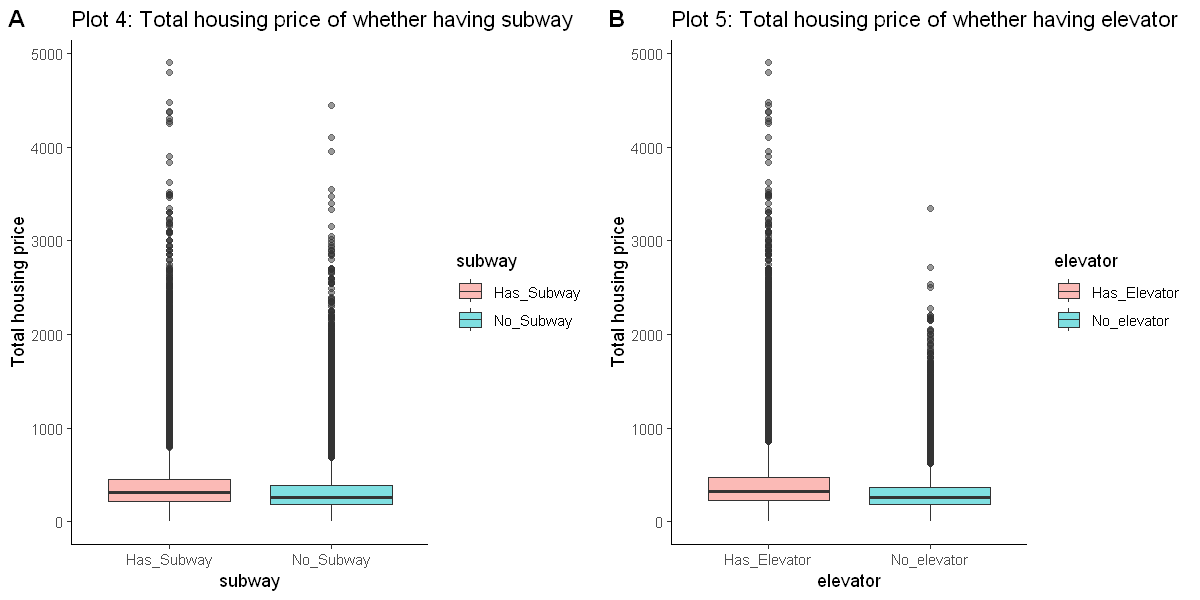

In [23]:
options(repr.plot.width=10, repr.plot.height=5)
# First plot
plot1 <- ggplot(beijing_house_price_cleaned, aes(x=subway, y=totalPrice, fill=subway)) + 
   geom_boxplot(alpha=0.5) +
   labs(title = "Plot 4: Total housing price of whether having subway", 
        y = "Total housing price") +
   theme_classic() 

# Second plot
plot2 <- ggplot(beijing_house_price_cleaned, aes(x=elevator, y=totalPrice, fill=elevator)) + 
   geom_boxplot(alpha=0.5) +
   labs(title = "Plot 5: Total housing price of whether having elevator",
        y = "Total housing price") +
   theme_classic() 

# Combine the plots using plot_grid from cowplot
plot_grid(plot1, plot2, labels = "AUTO")

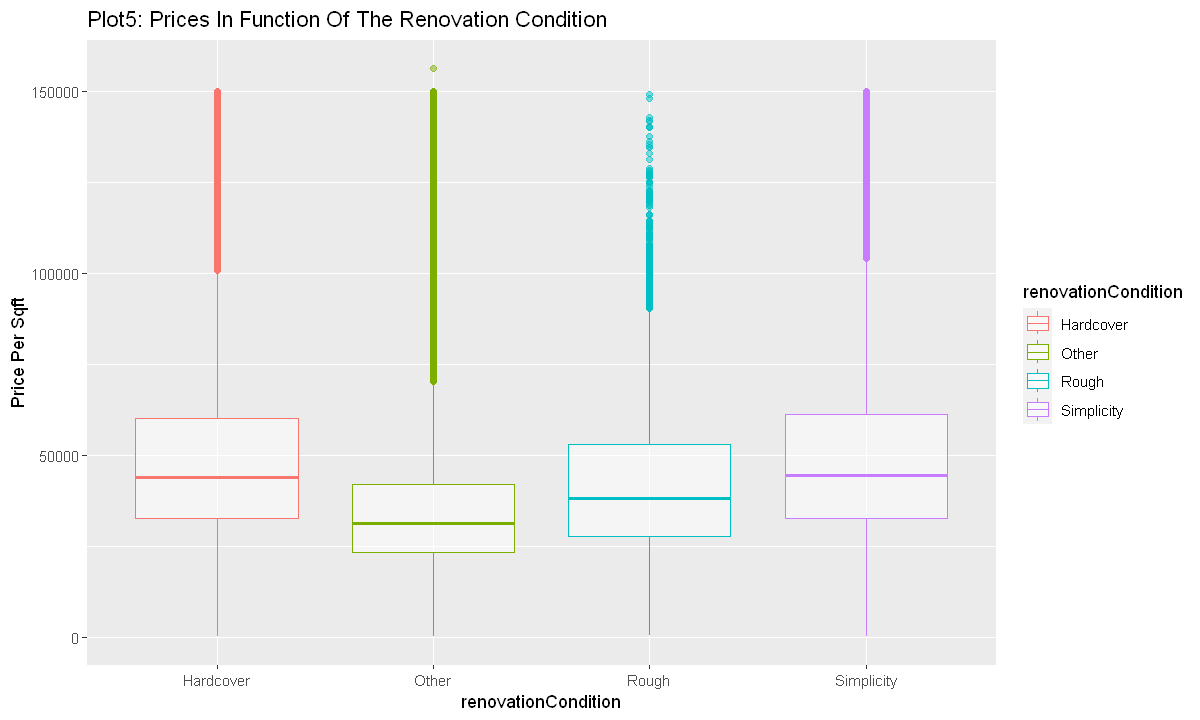

In [24]:
# Graph 5: Prices In Function Of The Renovation Condition
options(repr.plot.width=10, repr.plot.height=6)
renovation_condition_plot <- ggplot(beijing_house_price_cleaned, aes(x = renovationCondition, y = price, color = renovationCondition)) +
   geom_boxplot(alpha=0.5) + 
   labs(title = "Plot5: Prices In Function Of The Renovation Condition", 
        y = "Price Per Sqft") 
renovation_condition_plot

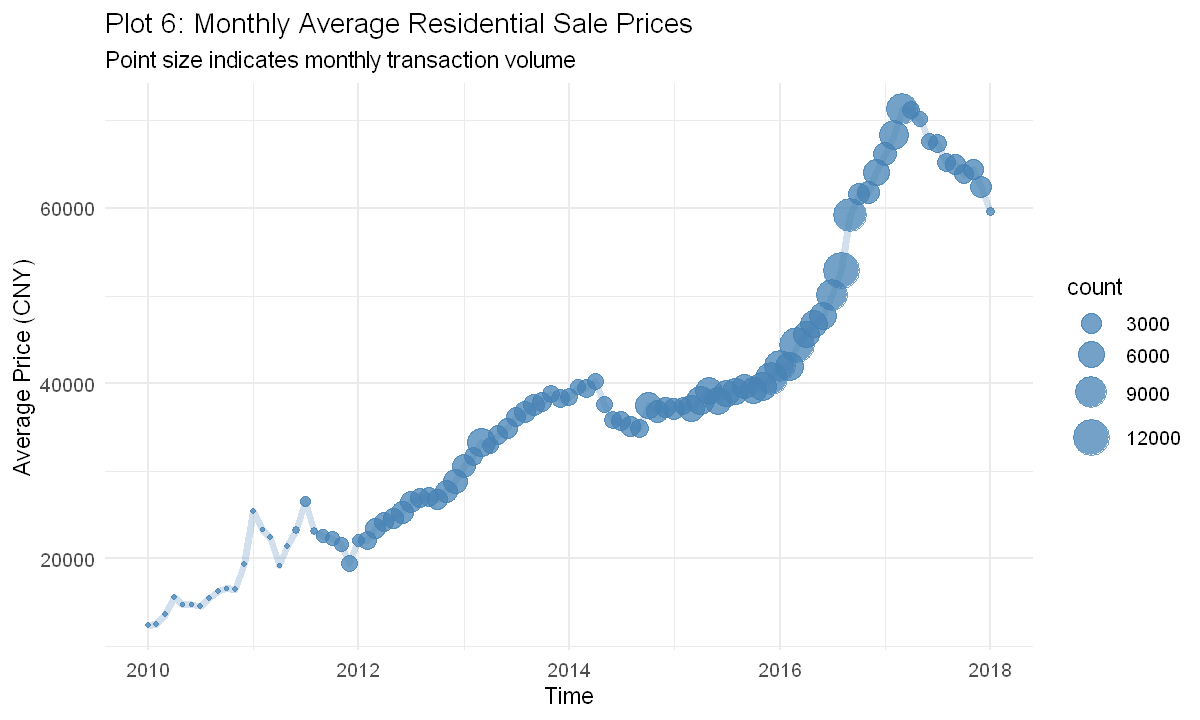

In [43]:
# Assuming the beijing_house_price dataset has been loaded
# Convert 'tradeTime' to Date format, assuming it's already in the proper format
beijing_house_price <- beijing_house_price %>%
  mutate(
    tradeTime = as.Date(tradeTime), # Assures 'tradeTime' is in Date format
    year = year(tradeTime), # Extracts year from 'tradeTime'
    month = month(tradeTime), # Extracts numeric month from 'tradeTime'
    # Generates the first day of each month for time series analysis
    monthlyTradeTS = as.Date(paste(year, month, "01", sep="-"))
  )

# Aggregate the data to get a count of trades and the mean price for each month after 2009
monthly_price_overview <- beijing_house_price %>%
  filter(year(tradeTime) > 2009) %>% # Filters out the data before 2010
  group_by(monthlyTradeTS) %>%
  summarise(
    count = n(), # Counts the number of trades per month
    mean_price = mean(price, na.rm = TRUE) # Calculates the mean price, excluding NA values
  )

# Plotting the time series of the average monthly traded house prices
# The size of the points reflects the number of houses traded each month
time_series_plot <- ggplot(monthly_price_overview, aes(x = monthlyTradeTS, y = mean_price)) + 
  geom_line(size = 2, alpha = .25, color = 'steelblue') +
  geom_point(aes(size = count), alpha = .75, color = 'steelblue') +
  theme_minimal(base_size = 14) +
  labs(
    title = 'Plot 6: Monthly Average Residential Sale Prices',
    subtitle = 'Point size indicates monthly transaction volume',
    x = "Time", 
    y = "Average Price (CNY)"
  ) +
  scale_size(range = c(1, 10))
time_series_plot

Loading objects:
  beijing


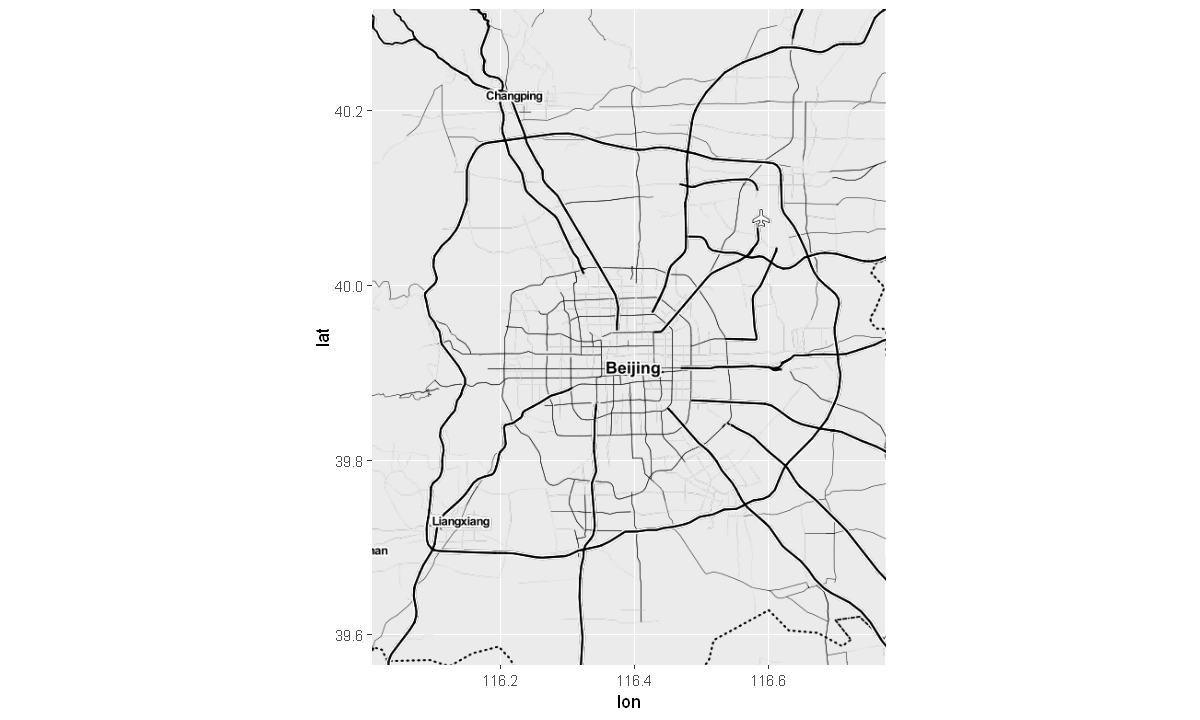

In [37]:
load(file = "data/beijing_map.RData",verbose = TRUE)
beijing

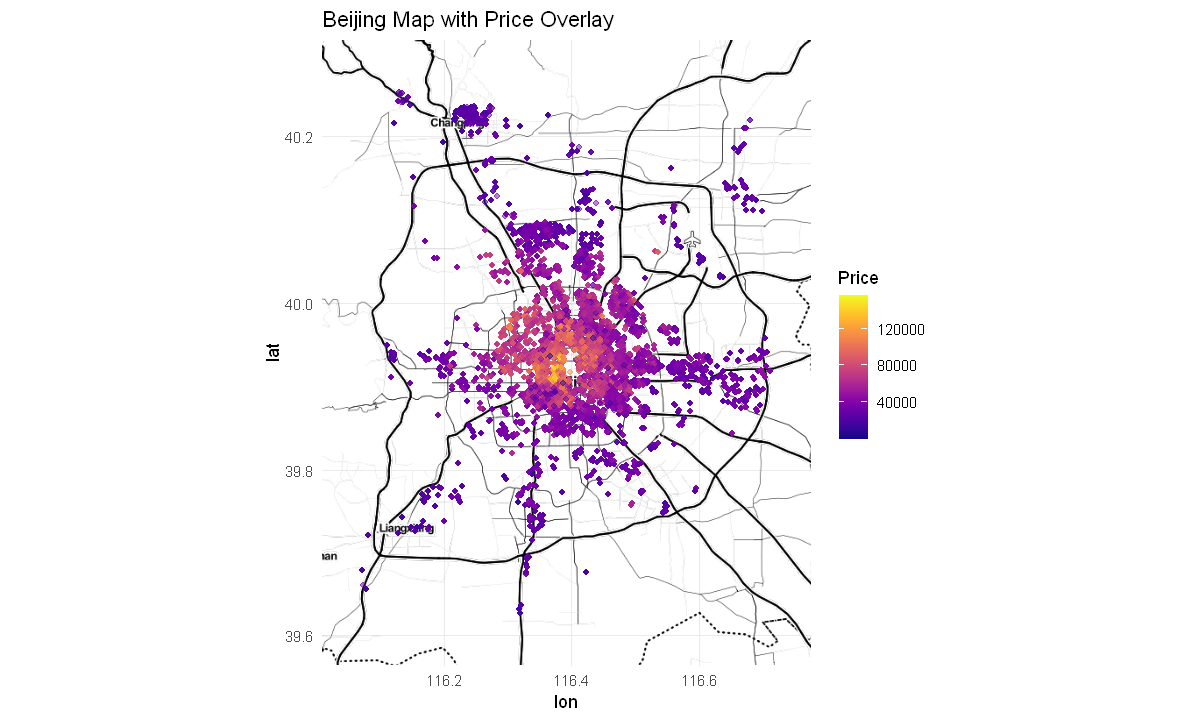

In [42]:
beijing_map_plot <- beijing + 
  geom_point(data = beijing_house_price_cleaned, aes(x = Lng, y = Lat, color = price), size = 1.3, alpha = 0.5) +
  scale_color_viridis(option = "C") +  # Use 'option' to select the viridis color scale you prefer
  theme_minimal() +  # Use a minimal theme
  labs(title = "Beijing Map with Price Overlay", 
       color = "Price")  # Label for the color scale
beijing_map_plot

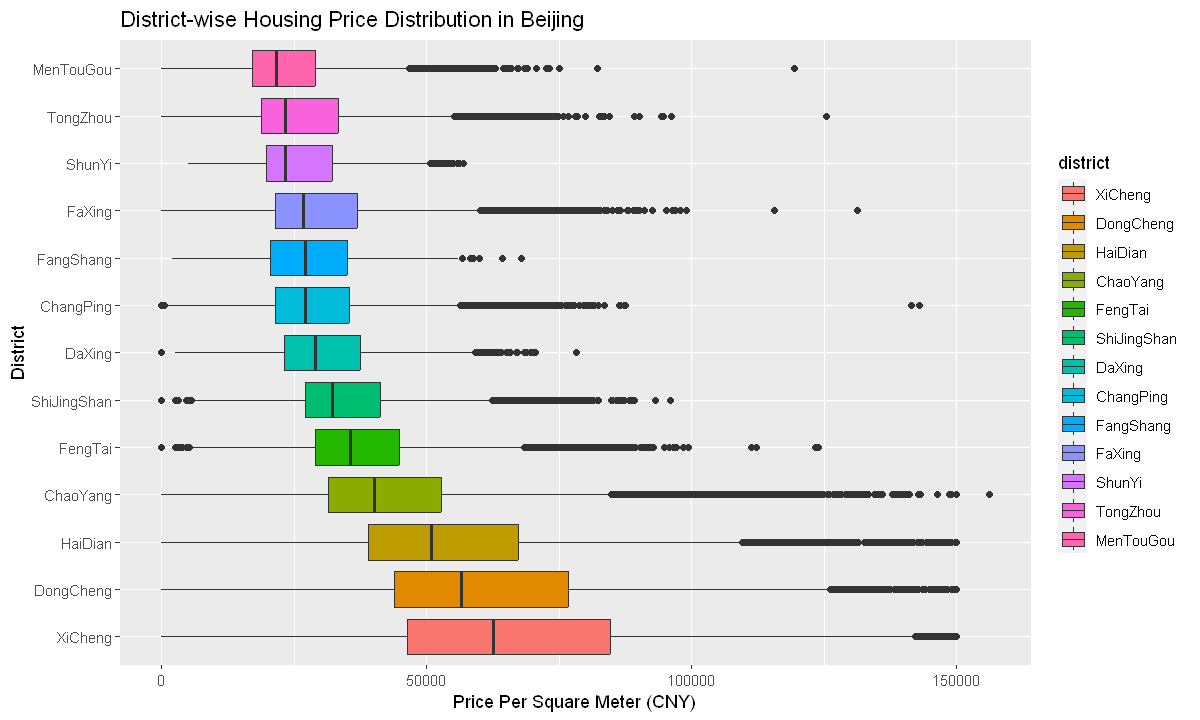

In [57]:
# Assuming beijing_house_price_cleaned is your cleaned dataset
# First, group data by 'district', calculate the median price for each district,
# and reorder districts based on their median price in descending order
beijing_house_price <- beijing_house_price_cleaned %>%
  group_by(district) %>%
  mutate(median_price = median(price, na.rm = TRUE)) %>%
  ungroup() %>%
  mutate(district = reorder(district, -median_price))

# Create a boxplot visualizing housing prices across districts
# with districts ordered by their median housing price
boxplot_price_district <- ggplot(beijing_house_price, aes(x = district, y = price, fill = district)) +
  geom_boxplot() +  # Add boxplot layer
  labs(
    title = "District-wise Housing Price Distribution in Beijing", 
    x = "District", 
    y = "Price Per Square Meter (CNY)"
  ) +
  coord_flip()  # Flip coordinates for horizontal boxplot presentation

# Display the boxplot
boxplot_price_district

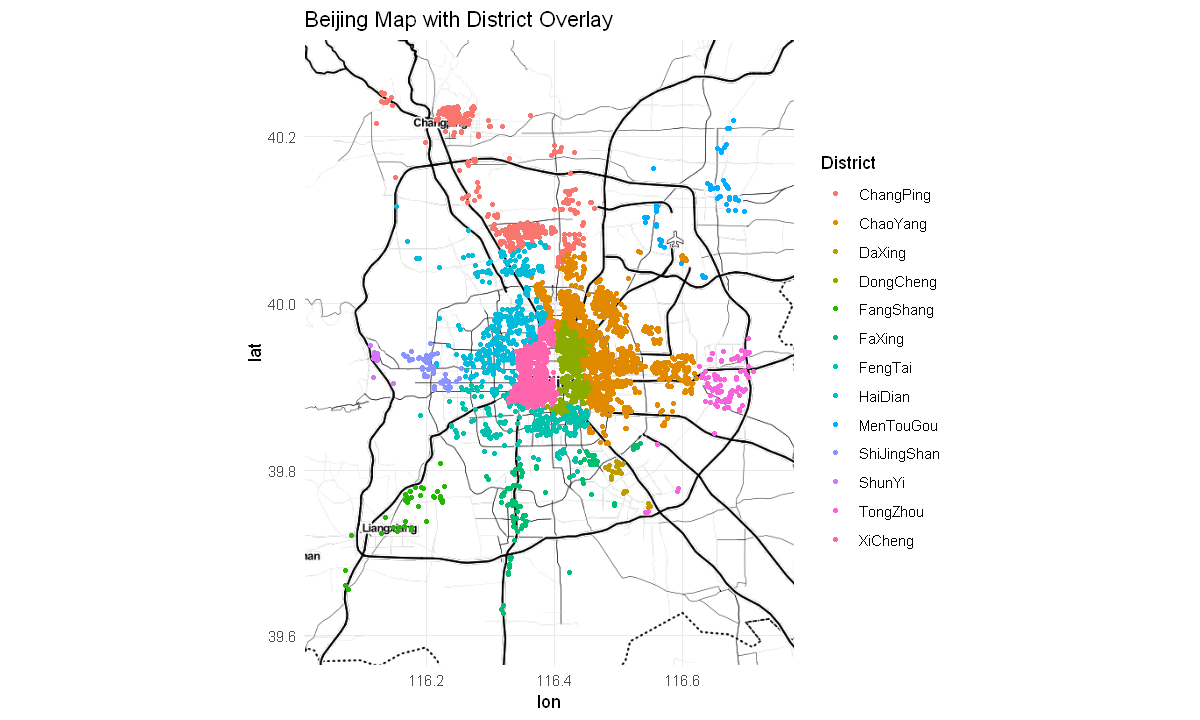

: 

In [61]:
map_with_points <- beijing + 
  geom_point(data = beijing_house_price_cleaned, aes(x = Lng, y = Lat, color = district), size = 1.2, alpha = 1) +
  theme_minimal() +  # Use a minimal theme as a base for cleanliness
  theme(
    plot.background = element_rect(fill = "white", colour = NA),  # Set plot background to white
    panel.background = element_rect(fill = "white", colour = NA)
  ) +
  labs(
    title = "Beijing Map with District Overlay",  # Correct placement for title to appear
    color = "District"  # Label for the color scale
  )
map_with_points